# Feature Detection and Matching Test

## Import the needed module

In [24]:
import cv2
import time
import random
import numpy as np
import matplotlib.pyplot as plt

## Image loading and transformation

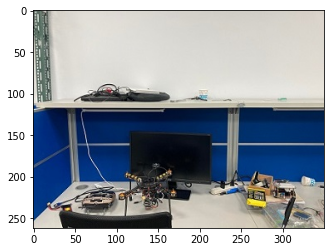

In [25]:
raw_image = cv2.imread('./images/image1.jpg')
raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)
plt.imshow(raw_image)

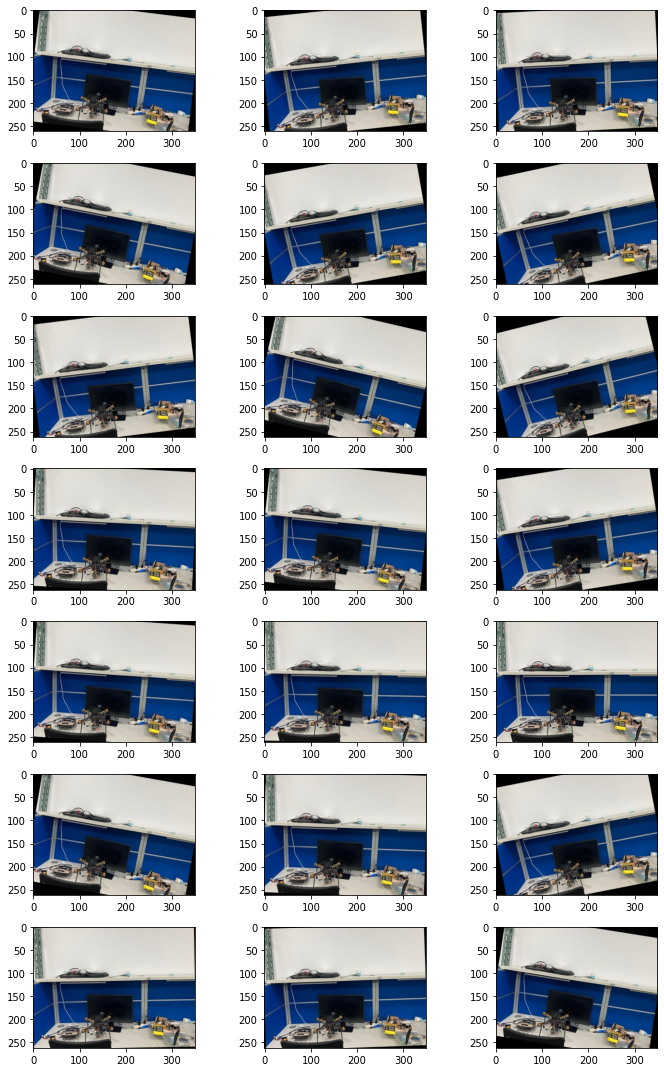

In [79]:
# Get the geometry information of the raw image
(h, w, d) = raw_image.shape
center = (w // 2, h // 2)

angle = random.sample(range(-15, 16), 21)
rotate_image = []
for i in angle:
    matrix = cv2.getRotationMatrix2D(center, i, 1.0)
    rotate_image.append(cv2.warpAffine(raw_image, matrix, (w, h)))

rows, cols, index = 7, 3, 1
axes = []
fig = plt.figure(figsize=(10, 15))
for images in rotate_image:
    axes.append(fig.add_subplot(rows, cols, index))
    plt.imshow(images)
    index += 1
    
plt.tight_layout()
plt.show()

# SIFT

Number of Keypoints Detected In The Training Image:  320
Number of Keypoints Detected In The Query Image:  372
Detecion time: 0.021019697189331055 secs


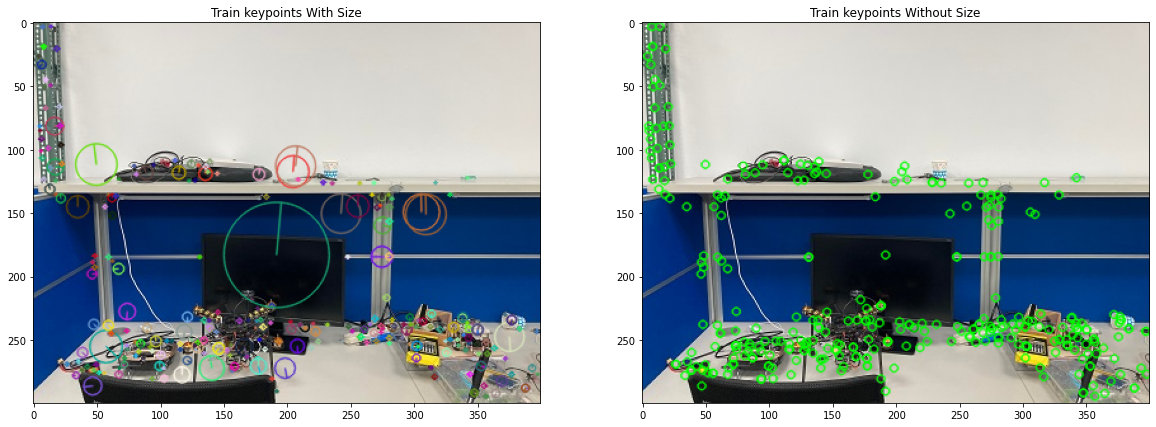

In [36]:
# Covert the image to gray
train_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
test_gray = cv2.cvtColor(rotated_image, cv2.COLOR_RGB2GRAY)

# create the sift extractor-
sift = cv2.SIFT_create()

start = time.time()
train_keypoints, train_descriptor = sift.detectAndCompute(train_gray, None)
end = time.time()
test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(image)
keypoints_with_size = np.copy(image)

cv2.drawKeypoints(image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

print("Detecion time: {} secs".format(end - start))

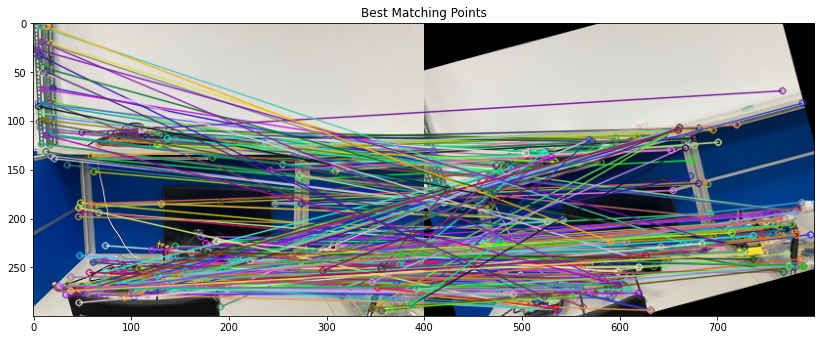


Number of Matching Keypoints Between The Training and Query Images:  320
Matching Duration: 0.001977205276489258 secs


In [37]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)

# Perform the matching between the SIFT descriptors of the training image and the test image
start = time.time()
matches = bf.match(train_descriptor, test_descriptor)
end = time.time()

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(image, train_keypoints, rotated_image, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))
print("Matching Duration: {} secs".format(end - start) )

In [42]:
import pandas as pd
import seaborn as sns

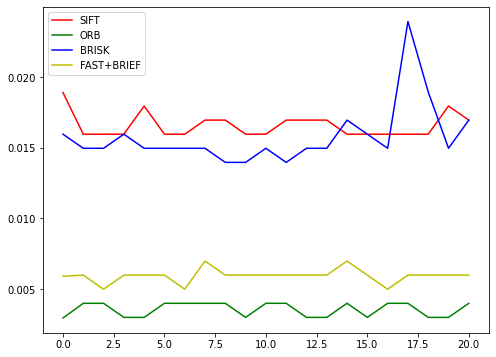

In [82]:
# Test SIFT for all rotated image
# row image process
train_gray = cv2.cvtColor(raw_image, cv2.COLOR_RGB2GRAY)
sift = cv2.SIFT_create()
train_keypoints, train_descriptor = sift.detectAndCompute(train_gray, None)
bf_sift = cv2.BFMatcher(cv2.NORM_L1, crossCheck = False)


time_orb = []
time_sift = []
time_brisk = []
time_fbrief = []
for image in rotate_image:
    test_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    start = time.time()
    test_keypoints, test_descriptor = sift.detectAndCompute(test_gray, None)
    matches = bf_sift.match(train_descriptor, test_descriptor)
    end  = time.time()
    duration = end - start
    time_sift.append(duration)
    
orb = cv2.ORB_create()
train_keypoints, train_descriptor = orb.detectAndCompute(train_gray, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
for image in rotate_image:
    test_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    start = time.time()
    test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)
    matches = bf.match(train_descriptor, test_descriptor)
    end  = time.time()
    duration = end - start
    time_orb.append(duration)

brisk = cv2.BRISK_create()
train_keypoints, train_descriptor = brisk.detectAndCompute(train_gray, None)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
for image in rotate_image:
    test_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    start = time.time()
    test_keypoints, test_descriptor = brisk.detectAndCompute(test_gray, None)
    matches = bf.match(train_descriptor, test_descriptor)
    end  = time.time()
    duration = end - start
    time_brisk.append(duration)
    
fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d_BriefDescriptorExtractor.create()
train_keypoints = fast.detect(train_gray, None)
train_keypoints, train_descriptor = brief.compute(train_gray, train_keypoints)
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

for image in rotate_image:
    test_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    start = time.time()
    test_keypoints = fast.detect(test_gray, None)
    test_keypoints, test_descriptor = brief.compute(test_gray, test_keypoints)
    matches = bf.match(train_descriptor, test_descriptor)
    end  = time.time()
    duration = end - start
    time_fbrief.append(duration)  
    
plt.figure(figsize=(8,6))
plt.plot(time_sift, color='r', label='SIFT')
plt.plot(time_orb, color='g', label='ORB')
plt.plot(time_brisk, color='b', label='BRISK')
plt.plot(time_fbrief, color='y', label='FAST+BRIEF')
plt.legend(loc = "upper left", fontsize=10)
plt.show()
# sns.boxplot(data=[time_sift, time_orb])

## SURF

Non-Free in OpenCV due to the Patend. The anticipated expiration release in 2033.

## ORB

Number of Keypoints Detected In The Training Image:  464
Number of Keypoints Detected In The Query Image:  473
Detecion time: 0.002991914749145508 secs


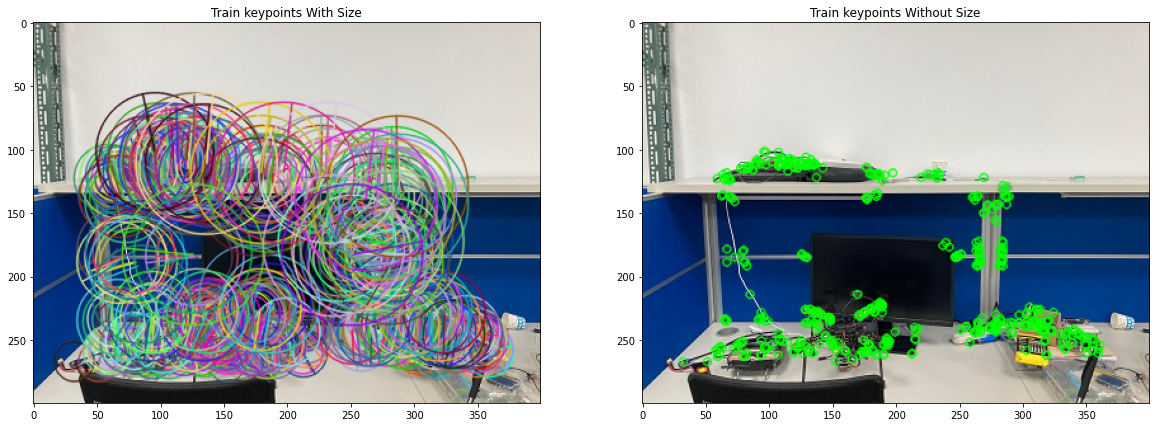

In [38]:
# Covert the image to gray
train_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
test_gray = cv2.cvtColor(rotated_image, cv2.COLOR_RGB2GRAY)

orb = cv2.ORB_create()

start = time.time()
train_keypoints, train_descriptor = orb.detectAndCompute(train_gray, None)
end = time.time()
test_keypoints, test_descriptor = orb.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(image)
keypoints_with_size = np.copy(image)

cv2.drawKeypoints(image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

print("Detecion time: {} secs".format(end - start))

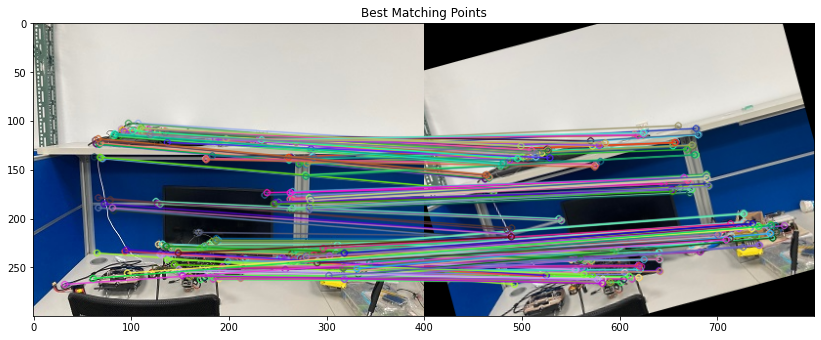


Number of Matching Keypoints Between The Training and Query Images:  285
Matching Duration: 0.0009968280792236328 secs


In [39]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the SIFT descriptors of the training image and the test image
start = time.time()
matches = bf.match(train_descriptor, test_descriptor)
end = time.time()

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(image, train_keypoints, rotated_image, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))
print("Matching Duration: {} secs".format(end - start) )

## FAST + BRIEF

Number of Keypoints Detected In The Training Image:  1082
Number of Keypoints Detected In The Query Image:  936
Detecion time: 0.003989696502685547 secs


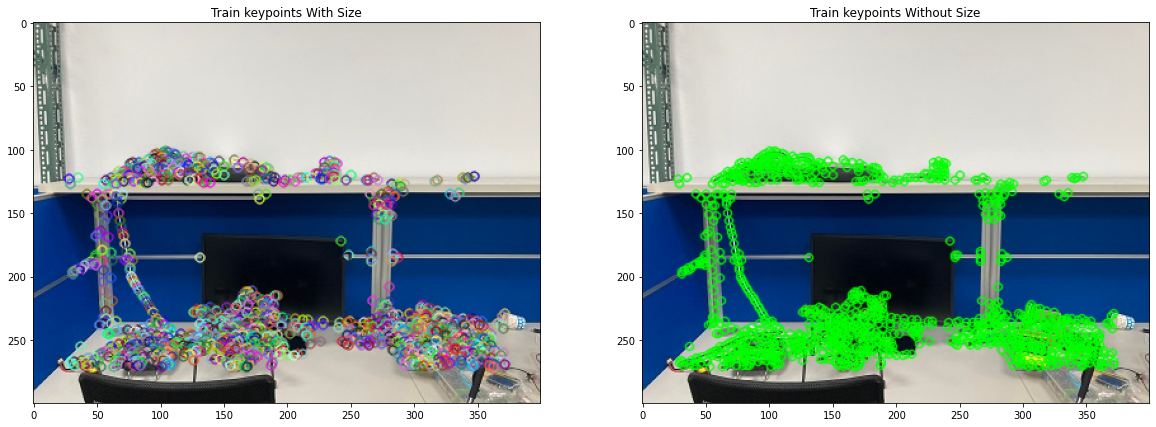

In [40]:
fast = cv2.FastFeatureDetector_create()
brief = cv2.xfeatures2d_BriefDescriptorExtractor.create()

start = time.time()
train_keypoints = fast.detect(train_gray, None)
train_keypoints, train_descriptor = brief.compute(train_gray, train_keypoints)
end = time.time()

test_keypoints = fast.detect(test_gray, None)
test_keypoints, test_descriptor = brief.compute(test_gray, test_keypoints)

keypoints_without_size = np.copy(image)
keypoints_with_size = np.copy(image)

cv2.drawKeypoints(image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

print("Detecion time: {} secs".format(end - start))

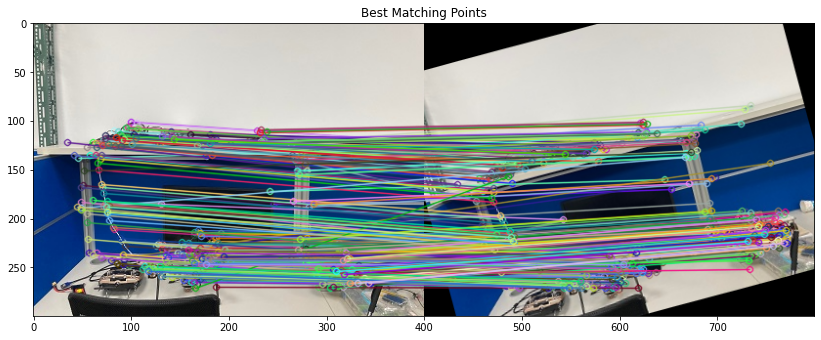


Number of Matching Keypoints Between The Training and Query Images:  382
Matching Duration: 0.005970478057861328 secs


In [41]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the SIFT descriptors of the training image and the test image
start = time.time()
matches = bf.match(train_descriptor, test_descriptor)
end = time.time()

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(image, train_keypoints, rotated_image, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))
print("Matching Duration: {} secs".format(end - start) )

## BRISK

Number of Keypoints Detected In The Training Image:  1101
Number of Keypoints Detected In The Query Image:  835
Detecion time: 0.017000436782836914 secs


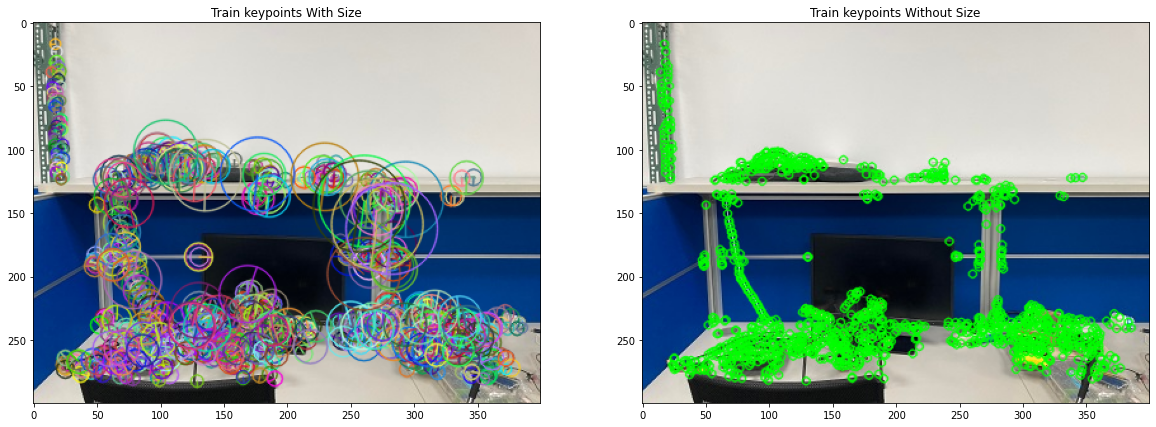

In [44]:
# Covert the image to gray
train_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
test_gray = cv2.cvtColor(rotated_image, cv2.COLOR_RGB2GRAY)

brisk = cv2.BRISK_create()

start = time.time()
train_keypoints, train_descriptor = brisk.detectAndCompute(train_gray, None)
end = time.time()
test_keypoints, test_descriptor = brisk.detectAndCompute(test_gray, None)

keypoints_without_size = np.copy(image)
keypoints_with_size = np.copy(image)

cv2.drawKeypoints(image, train_keypoints, keypoints_without_size, color = (0, 255, 0))

cv2.drawKeypoints(image, train_keypoints, keypoints_with_size, flags = cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display image with and without keypoints size
fx, plots = plt.subplots(1, 2, figsize=(20,10))

plots[0].set_title("Train keypoints With Size")
plots[0].imshow(keypoints_with_size, cmap='gray')

plots[1].set_title("Train keypoints Without Size")
plots[1].imshow(keypoints_without_size, cmap='gray')

# Print the number of keypoints detected in the training image
print("Number of Keypoints Detected In The Training Image: ", len(train_keypoints))

# Print the number of keypoints detected in the query image
print("Number of Keypoints Detected In The Query Image: ", len(test_keypoints))

print("Detecion time: {} secs".format(end - start))

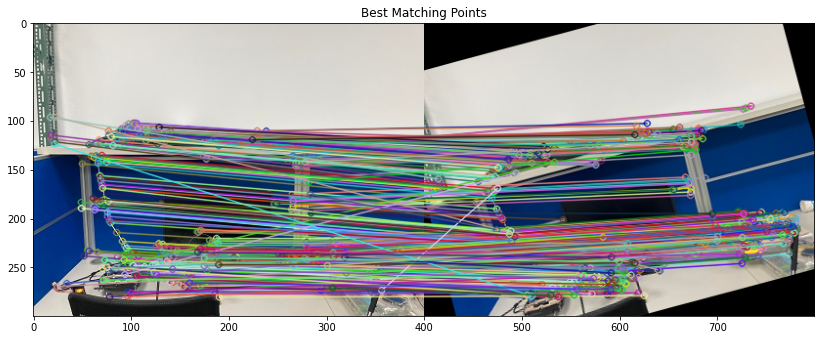


Number of Matching Keypoints Between The Training and Query Images:  533
Matching Duration: 0.005982398986816406 secs


In [45]:
# Create a Brute Force Matcher object.
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)

# Perform the matching between the SIFT descriptors of the training image and the test image
start = time.time()
matches = bf.match(train_descriptor, test_descriptor)
end = time.time()

# The matches with shorter distance are the ones we want.
matches = sorted(matches, key = lambda x : x.distance)

result = cv2.drawMatches(image, train_keypoints, rotated_image, test_keypoints, matches, test_gray, flags = 2)

# Display the best matching points
plt.rcParams['figure.figsize'] = [14.0, 7.0]
plt.title('Best Matching Points')
plt.imshow(result)
plt.show()

# Print total number of matching points between the training and query images
print("\nNumber of Matching Keypoints Between The Training and Query Images: ", len(matches))
print("Matching Duration: {} secs".format(end - start) )